# Deep Q-Network implementation.

This homework shamelessly demands you to implement DQN — an approximate Q-learning algorithm with experience replay and target networks — and see if it works any better this way.

Original paper:
https://arxiv.org/pdf/1312.5602.pdf

Acknowledgements for this homework to the [Practical_RL](https://github.com/yandexdataschool/Practical_RL) course team.

**This notebook is given for debug.** The main task is in the other notebook (**homework_pytorch_main**). The tasks are similar and share most of the code. The main difference is in environments. In main notebook it can take some 2 hours for the agent to start improving so it seems reasonable to launch the algorithm on a simpler env first. Here it is CartPole and it will train in several minutes.

**We suggest the following pipeline:** First implement debug notebook then implement the main one.

**About evaluation:** All points are given for the main notebook with one exception: if agent fails to beat the threshold in main notebook you can get 1 pt (instead of 3 pts) for beating the threshold in debug notebook.

In [96]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
        
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/atari_wrappers.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/utils.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/replay_buffer.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/framebuffer.py

    !pip install gym[box2d]

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for PyTorch, but you find it easy to adapt it to almost any Python-based deep learning framework.

In [97]:
import random
import numpy as np
import torch
import utils

In [98]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### CartPole again

Another env can be used without any modification of the code. State space should be a single vector, actions should be discrete.

CartPole is the simplest one. It should take several minutes to solve it.

For LunarLander it can take 1-2 hours to get 200 points (a good score) on Colab and training progress does not look informative.

In [4]:
ENV_NAME = 'CartPole-v1'

def make_env(seed=None):
    # some envs are wrapped with a time limit wrapper by default
    env = gym.make(ENV_NAME).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


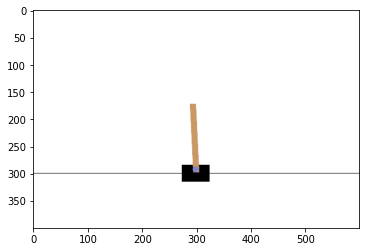

In [5]:
env = make_env()
env.reset()
plt.imshow(env.render("rgb_array"))
state_shape, n_actions = env.observation_space.shape, env.action_space.n

### Building a network

We now need to build a neural network that can map observations to state q-values.
The model does not have to be huge yet. 1-2 hidden layers with < 200 neurons and ReLU activation will probably be enough. Batch normalization and dropout can spoil everything here.

In [6]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')
device

device(type='cuda')

In [21]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        # Define your network body here. Please make sure agent is fully contained here
        assert len(state_shape) == 1
        state_dim = state_shape[0]
        self.model = nn.Sequential(
            nn.Linear(state_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, self.n_actions)
        )

        
    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch states, shape = [batch_size, *state_dim=4]
        """
        # Use your network to compute qvalues for given state
        qvalues = self.model(state_t)

        assert qvalues.requires_grad, "qvalues must be a torch tensor with grad"
        assert (
            len(qvalues.shape) == 2 and 
            qvalues.shape[0] == state_t.shape[0] and 
            qvalues.shape[1] == n_actions
        )

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [22]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

Now let's try out our agent to see if it raises any errors.

In [23]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [24]:
evaluate(env, agent, n_games=1)

13.0

### Experience replay
For this assignment, we provide you with experience replay buffer. If you implemented experience replay buffer in last week's assignment, you can copy-paste it here in main notebook **to get 2 bonus points**.

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png)

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [25]:
import random
from collections import deque


class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._storage = []
        self._maxsize = size

        # OPTIONAL: YOUR CODE
        self._storage = deque([], maxlen=self._maxsize)

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize. 
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)

        # add data to storage
        self._storage.append(data)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        if (len(self._storage) == 0):
          return None
        idxes = np.random.choice(len(self._storage), size=batch_size)

        # collect <s,a,r,s',done> for each index

        return (
            np.array([self._storage[i][0] for i in idxes]),
            np.array([self._storage[i][1] for i in idxes]),
            np.array([self._storage[i][2] for i in idxes]),
            np.array([self._storage[i][3] for i in idxes]),
            np.array([self._storage[i][4] for i in idxes]),
            )

In [26]:
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(), 1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [47]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n_steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    for _ in range(n_steps):
      q_values = agent.get_qvalues([s])
      a = agent.sample_actions(q_values)
      next_s, r, done, _, _ = env.step(a[0])
      sum_rewards += r
      exp_replay.add(s, a[0], r, next_s, done)
      if done:
        s = env.reset()
      else:
        s = next_s
    

    return sum_rewards, s

In [48]:
# testing your code.
exp_replay = ReplayBuffer(2000)

state = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, \
    "play_and_record should have added exactly 1000 steps, " \
    "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, \
    "Please make sure you restart the game whenever it is 'done' and " \
    "record the is_done correctly into the buffer. Got %f is_done rate over " \
    "%i steps. [If you think it's your tough luck, just re-run the test]" % (
        np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (10,), \
        "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (10,), \
        "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (10,), \
        "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1) for i in is_dones], \
        "is_done should be strictly True or False"
    assert [0 <= a < n_actions for a in act_batch], "actions should be within [0, n_actions)"

print("Well done!")

Well done!


### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png)

In [49]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes Q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.


__Note 1:__ there's an example input below. Feel free to experiment with it before you write the function.

__Note 2:__ compute_td_loss is a source of 99% of bugs in this homework. If reward doesn't improve, it often helps to go through it line by line [with a rubber duck](https://rubberduckdebugging.com/).

In [78]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float32)    # shape: [batch_size, *state_shape]
    actions = torch.tensor(actions, device=device, dtype=torch.int64)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float32,
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)  # shape: [batch_size, n_actions]

    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)  # shape: [batch_size, n_actions]
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]  # shape: [batch_size]

    # compute V*(next_states) using predicted next q-values
    next_state_values, _ = predicted_next_qvalues.max(dim=1)

    assert predicted_qvalues_for_actions.dim() == 1 and predicted_qvalues_for_actions.shape[0] == states.shape[0]
    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0], \
        "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards + gamma*is_not_done*next_state_values

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, \
            "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim() == 1, \
            "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim() == 1, \
            "there's something wrong with target q-values, they must be a vector"

    return loss

Sanity checks

In [79]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (), \
    "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() != 0), \
    "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), \
    "target network should not have grads"

### Main loop

It's time to put everything together and see if it learns anything.

In [80]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [81]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [82]:
env = make_env(seed)
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


<All keys matched successfully>

In [83]:
REPLAY_BUFFER_SIZE = 10**4

exp_replay = ReplayBuffer(REPLAY_BUFFER_SIZE)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available. 
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
             )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == REPLAY_BUFFER_SIZE:
        break
print(len(exp_replay))

10000


In [84]:
# # for something more complicated than CartPole

# timesteps_per_epoch = 1
# batch_size = 32
# total_steps = 3 * 10**6
# decay_steps = 1 * 10**6

# opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

# init_epsilon = 1
# final_epsilon = 0.1

# loss_freq = 20
# refresh_target_network_freq = 1000
# eval_freq = 5000

# max_grad_norm = 5000

In [85]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 4 * 10**4
decay_steps = 1 * 10**4

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

max_grad_norm = 5000

In [86]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []
step = 0

In [87]:
import time

def wait_for_keyboard_interrupt():
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        pass

buffer size = 10000, epsilon = 0.10000


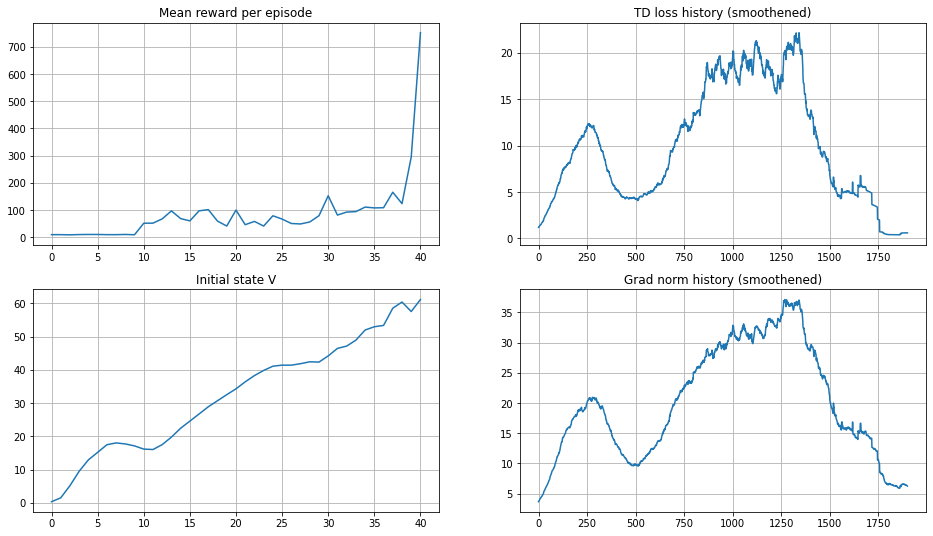

100%|██████████| 40001/40001 [02:34<00:00, 258.52it/s]


In [88]:
state = env.reset()
with trange(step, total_steps + 1) as progress_bar:
    for step in progress_bar:
        if not utils.is_enough_ram():
            print('less that 100 Mb RAM available, freezing')
            print('make sure everything is ok and use KeyboardInterrupt to continue')
            wait_for_keyboard_interrupt()

        agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

        # play
        _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

        # train
        batches = exp_replay.sample(batch_size)

        loss = compute_td_loss(*batches, agent, target_network)

        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
        opt.step()
        opt.zero_grad()

        if step % loss_freq == 0:
            td_loss_history.append(loss.data.cpu().item())
            grad_norm_history.append(grad_norm.cpu().item())

        if step % refresh_target_network_freq == 0:
            # Load agent weights into target_network
            target_network.load_state_dict(agent.state_dict())
            

        if step % eval_freq == 0:
            mean_rw_history.append(evaluate(
                make_env(seed=step), agent, n_games=3, greedy=True, t_max=1000)
            )
            initial_state_q_values = agent.get_qvalues(
                [make_env(seed=step).reset()]
            )
            initial_state_v_history.append(np.max(initial_state_q_values))

            clear_output(True)
            print("buffer size = %i, epsilon = %.5f" %
                (len(exp_replay), agent.epsilon))

            plt.figure(figsize=[16, 9])

            plt.subplot(2, 2, 1)
            plt.title("Mean reward per episode")
            plt.plot(mean_rw_history)
            plt.grid()

            assert not np.isnan(td_loss_history[-1])
            plt.subplot(2, 2, 2)
            plt.title("TD loss history (smoothened)")
            plt.plot(utils.smoothen(td_loss_history))
            plt.grid()

            plt.subplot(2, 2, 3)
            plt.title("Initial state V")
            plt.plot(initial_state_v_history)
            plt.grid()

            plt.subplot(2, 2, 4)
            plt.title("Grad norm history (smoothened)")
            plt.plot(utils.smoothen(grad_norm_history))
            plt.grid()

            plt.show()

In [105]:
final_score = evaluate(
  make_env(),
  agent, n_games=30, greedy=True, t_max=1000
)
print('final score:', final_score)
assert final_score > 300, 'not good enough for DQN'
print('Well done')


final score: 598.7666666666667
Well done


**Agent's predicted V-values vs their Monte-Carlo estimates**

In [106]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
eval_env = make_env()
record = utils.play_and_log_episode(eval_env, agent)
print('total reward for life:', np.sum(record['rewards']))
for key in record:
    print(key)

total reward for life: 2648.0
states
v_mc
v_agent
q_spreads
td_errors
rewards
episode_finished


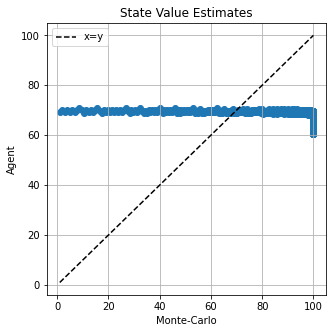

In [108]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(record['v_mc'], record['v_agent'])
ax.plot(sorted(record['v_mc']), sorted(record['v_mc']),
       'black', linestyle='--', label='x=y')

ax.grid()
ax.legend()
ax.set_title('State Value Estimates')
ax.set_xlabel('Monte-Carlo')
ax.set_ylabel('Agent')

plt.show()